In [58]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from onee.data.names import Aliases

In [50]:
from onee.data.loader import DataLoader

In [2]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [51]:
data_loader = DataLoader(PROJECT_ROOT)

In [3]:
import sqlite3

In [4]:
db = sqlite3.connect(PROJECT_ROOT / "data" / "all_data.db")

In [54]:
df_cd, _  = data_loader.load_cd_data(PROJECT_ROOT / "data" / "all_data.db")

In [57]:
df_cd.columns

Index(['region', 'partenaire', 'contrat', 'annee', 'mois', 'activite',
       'consommation_kwh', 'consommation_zconhc', 'consommation_zconhl',
       'consommation_zconhp', 'niveau_tension', 'puissance_facturee',
       'puissance_appelee', 'date_emmenagement', 'date_demenagement'],
      dtype='object')

In [77]:
def plot_consumption_by_year(df_cd, region=None):
    if region:
        df_cd = df_cd[df_cd[Aliases.REGION] == region]
    s = df_cd.groupby(Aliases.ANNEE)[Aliases.CONSOMMATION_KWH].sum()
    
    # Calculate overall growth rate (CAGR)
    years = len(s)
    if years > 1:
        overall_cagr = ((s.iloc[-1] / s.iloc[0]) ** (1 / (years - 1)) - 1) * 100
    else:
        overall_cagr = 0
    
    # Calculate growth rate for last 5 years
    if years >= 5:
        last_5_years = s.iloc[-5:]
        last_5_cagr = ((last_5_years.iloc[-1] / last_5_years.iloc[0]) ** (1 / 4) - 1) * 100
    else:
        last_5_cagr = overall_cagr
    
    # Plot
    s.index = pd.to_datetime(s.index, format="%Y")
    s.plot()
    
    # Add title with growth rates
    title = f"Consumption by Year"
    if region:
        title += f" - {region}"
    title += f"\nOverall CAGR: {overall_cagr:.2f}% | Last 5 Years CAGR: {last_5_cagr:.2f}%"
    plt.title(title)
    
    plt.ylabel("Consumption (kWh)")
    plt.xlabel("Year")
    plt.grid(True, alpha=0.3)
    plt.show()

In [82]:
from matplotlib.backends.backend_pdf import PdfPages

def create_consumption_report_pdf(df_cd, output_path="consumption_report.pdf"):
    """
    Create a PDF slide deck with consumption plots for all regions and overall.
    
    Parameters:
    -----------
    df_cd : DataFrame
        The consumption dataframe
    output_path : str
        Path where the PDF will be saved (default: "consumption_report.pdf")
    """
    # Get all unique regions and add None for overall
    regions = list(df_cd[Aliases.REGION].unique())
    regions_to_plot = [None] + regions  # None first for overall view
    
    # Create PDF
    with PdfPages(output_path) as pdf:
        for region in regions_to_plot:
            # Create a new figure for each region
            plt.figure(figsize=(12, 6))
            
            # Filter data if region is specified
            if region:
                df_filtered = df_cd[df_cd[Aliases.REGION] == region]
            else:
                df_filtered = df_cd
            
            # Calculate statistics
            s = df_filtered.groupby(Aliases.ANNEE)[Aliases.CONSOMMATION_KWH].sum()
            years = len(s)
            
            if years > 1:
                overall_cagr = ((s.iloc[-1] / s.iloc[0]) ** (1 / (years - 1)) - 1) * 100
            else:
                overall_cagr = 0
            
            if years >= 5:
                last_5_years = s.iloc[-5:]
                last_5_cagr = ((last_5_years.iloc[-1] / last_5_years.iloc[0]) ** (1 / 4) - 1) * 100
            else:
                last_5_cagr = overall_cagr
            
            # Plot
            s.index = pd.to_datetime(s.index, format="%Y")
            s.plot(linewidth=2, color='#2E86AB')
            
            # Add title with growth rates
            title = f"Consumption by Year - {'All Regions' if region is None else region}"
            title += f"\nOverall CAGR: {overall_cagr:.2f}% | Last 5 Years CAGR: {last_5_cagr:.2f}%"
            plt.title(title, fontsize=14, fontweight='bold')
            
            plt.ylabel("Consumption (kWh)", fontsize=12)
            plt.xlabel("Year", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            # Save the current figure to PDF
            pdf.savefig()
            plt.close()
            
            print(f"Added {'All Regions' if region is None else region} to PDF")
    
    print(f"\nPDF report saved to: {output_path}")

In [79]:
def create_detailed_consumption_report_pdf(df_cd, df_region_features, output_path="detailed_consumption_report.pdf"):
    """
    Create a detailed PDF slide deck with consumption plots and contract evolution for all regions.
    For each region: title slide, consumption evolution, and active contracts evolution.
    
    Parameters:
    -----------
    df_cd : DataFrame
        The consumption dataframe
    df_region_features : DataFrame
        The region features dataframe with total_active_contrats column
    output_path : str
        Path where the PDF will be saved (default: "detailed_consumption_report.pdf")
    """
    # Get all unique regions and add None for overall
    regions = list(df_cd[Aliases.REGION].unique())
    regions_to_plot = [None] + regions  # None first for overall view
    
    # Create PDF
    with PdfPages(output_path) as pdf:
        for region in regions_to_plot:
            region_name = 'All Regions' if region is None else region
            
            # ========== SLIDE 1: Title Slide ==========
            fig = plt.figure(figsize=(12, 6))
            fig.text(0.5, 0.5, region_name, 
                    ha='center', va='center', 
                    fontsize=36, fontweight='bold',
                    color='#2E86AB')
            fig.text(0.5, 0.35, 'Consumption & Contracts Analysis', 
                    ha='center', va='center', 
                    fontsize=20, color='#666666')
            plt.axis('off')
            pdf.savefig()
            plt.close()
            
            # ========== SLIDE 2: Consumption Evolution ==========
            plt.figure(figsize=(12, 6))
            
            # Filter data if region is specified
            if region:
                df_filtered = df_cd[df_cd[Aliases.REGION] == region]
            else:
                df_filtered = df_cd
            
            # Calculate statistics
            s = df_filtered.groupby(Aliases.ANNEE)[Aliases.CONSOMMATION_KWH].sum()
            years = len(s)
            
            if years > 1:
                overall_cagr = ((s.iloc[-1] / s.iloc[0]) ** (1 / (years - 1)) - 1) * 100
            else:
                overall_cagr = 0
            
            if years >= 5:
                last_5_years = s.iloc[-5:]
                last_5_cagr = ((last_5_years.iloc[-1] / last_5_years.iloc[0]) ** (1 / 4) - 1) * 100
            else:
                last_5_cagr = overall_cagr
            
            # Plot
            s.index = pd.to_datetime(s.index, format="%Y")
            s.plot(linewidth=2, color='#2E86AB')
            
            # Add title with growth rates
            title = f"Consumption Evolution - {region_name}"
            title += f"\nOverall CAGR: {overall_cagr:.2f}% | Last 5 Years CAGR: {last_5_cagr:.2f}%"
            plt.title(title, fontsize=14, fontweight='bold')
            
            plt.ylabel("Consumption (kWh)", fontsize=12)
            plt.xlabel("Year", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            # Save to PDF
            pdf.savefig()
            plt.close()
            
            # ========== SLIDE 3: Active Contracts Evolution (skip for Total) ==========
            if region is not None:  # Only for individual regions
                plt.figure(figsize=(12, 6))
                
                # Filter region features data
                df_region_filtered = df_region_features[df_region_features[Aliases.REGION] == region]
                
                # Plot total active contracts
                df_region_filtered = df_region_filtered.sort_values(Aliases.ANNEE)
                
                # Calculate Average Annual Increase (linear regression slope)
                import numpy as np
                from math import ceil
                
                years_contracts = df_region_filtered[Aliases.ANNEE].values
                contracts = df_region_filtered['total_active_contrats'].values
                
                # Overall average annual increase
                if len(years_contracts) > 1:
                    t_mean = np.mean(years_contracts)
                    x_mean = np.mean(contracts)
                    numerator = np.sum((years_contracts - t_mean) * (contracts - x_mean))
                    denominator = np.sum((years_contracts - t_mean) ** 2)
                    overall_aai = ceil(numerator / denominator) if denominator != 0 else 0
                else:
                    overall_aai = 0
                
                # Last 5 years average annual increase
                if len(years_contracts) >= 5:
                    years_contracts_5 = years_contracts[-5:]
                    contracts_5 = contracts[-5:]
                    t_mean_5 = np.mean(years_contracts_5)
                    x_mean_5 = np.mean(contracts_5)
                    numerator_5 = np.sum((years_contracts_5 - t_mean_5) * (contracts_5 - x_mean_5))
                    denominator_5 = np.sum((years_contracts_5 - t_mean_5) ** 2)
                    last_5_aai = ceil(numerator_5 / denominator_5) if denominator_5 != 0 else 0
                else:
                    last_5_aai = overall_aai
                
                plt.plot(df_region_filtered[Aliases.ANNEE], 
                        df_region_filtered['total_active_contrats'], 
                        linewidth=2, color='#A23B72', marker='o')
                
                title = f"Active Contracts Evolution - {region_name}"
                title += f"\nOverall Avg Annual Increase: {overall_aai:,} | Last 5 Years Avg Annual Increase: {last_5_aai:,}"
                plt.title(title, fontsize=14, fontweight='bold')
                plt.ylabel("Total Active Contracts", fontsize=12)
                plt.xlabel("Year", fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                
                # Save to PDF
                pdf.savefig()
                plt.close()
                
                # ========== SLIDE 4: Consumption per Contract ==========
                plt.figure(figsize=(12, 6))
                
                # Get consumption data for this region
                df_consumption = df_cd[df_cd[Aliases.REGION] == region]
                yearly_consumption = df_consumption.groupby(Aliases.ANNEE)[Aliases.CONSOMMATION_KWH].sum()
                
                # Merge with contracts data
                df_region_filtered = df_region_filtered.set_index(Aliases.ANNEE)
                yearly_consumption = yearly_consumption.reindex(df_region_filtered.index)
                
                # Calculate consumption per contract
                consumption_per_contract = yearly_consumption / df_region_filtered['total_active_contrats']
                
                # Plot
                plt.plot(consumption_per_contract.index, 
                        consumption_per_contract.values, 
                        linewidth=2, color='#F18F01', marker='o')
                
                plt.title(f"Consumption per Active Contract - {region_name}", 
                         fontsize=14, fontweight='bold')
                plt.ylabel("Consumption per Contract (kWh)", fontsize=12)
                plt.xlabel("Year", fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                
                # Save to PDF
                pdf.savefig()
                plt.close()
            
            print(f"Added {region_name} (with {'2' if region is None else '4'} slides)")
    
    print(f"\nDetailed PDF report saved to: {output_path}")

In [64]:
df_region_features = data_loader.compute_contract_features(df_cd, entity_col=Aliases.REGION)

C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\src\onee\data\loader.py:288: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [71]:
create_detailed_consumption_report_pdf(df_cd, df_region_features, output_path="detailed_consumption_report.pdf")

Added All Regions (with 2 slides)
Added Tanger-Tétouan-Al Hoceïma (with 4 slides)
Added Laâyoune-Sakia El Hamra (with 4 slides)
Added Drâa-Tafilalet (with 4 slides)
Added Rabat-Salé-Kénitra (with 4 slides)
Added Casablanca-Settat (with 4 slides)
Added Souss-Massa (with 4 slides)
Added Guelmim-Oued Noun (with 4 slides)


C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_2968\3595382484.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  overall_cagr = ((s.iloc[-1] / s.iloc[0]) ** (1 / (years - 1)) - 1) * 100


Added Oriental (with 4 slides)
Added Béni Mellal-Khénifra (with 4 slides)
Added Marrakech-Safi (with 4 slides)
Added Fès-Meknès (with 4 slides)

Detailed PDF report saved to: detailed_consumption_report.pdf


## Output

In [72]:
df_cd_output = pd.read_csv(PROJECT_ROOT / "ltf_cd_results.csv") 

In [73]:
df_cd_output.columns

Index(['Region', 'Partenaire', 'Contrat', 'Activity', 'Year',
       'Consommation_Total', 'Consommation_ZCONHC', 'Consommation_ZCONHL',
       'Consommation_ZCONHP', 'Puissance_Facturee', 'Niveau_tension'],
      dtype='object')

In [85]:
df_cd_output.rename(columns={"Consommation_Total": Aliases.CONSOMMATION_KWH, "Year": Aliases.ANNEE, "Region": Aliases.REGION}, inplace=True)

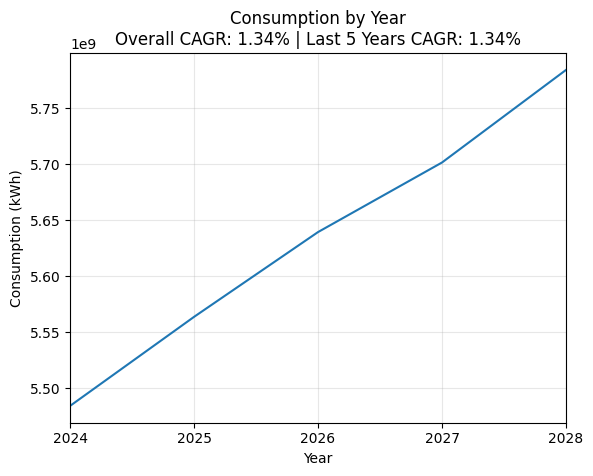

In [80]:
plot_consumption_by_year(df_cd_output, region=None)

In [87]:
create_consumption_report_pdf(df_cd_output, output_path="cd_consumption_evolution_predictions_fixed.pdf")

Added All Regions to PDF
Added Béni Mellal-Khénifra to PDF
Added Casablanca-Settat to PDF
Added Drâa-Tafilalet to PDF
Added Fès-Meknès to PDF
Added Guelmim-Oued Noun to PDF
Added Laâyoune-Sakia El Hamra to PDF
Added Marrakech-Safi to PDF
Added Oriental to PDF
Added Rabat-Salé-Kénitra to PDF
Added Souss-Massa to PDF
Added Tanger-Tétouan-Al Hoceïma to PDF

PDF report saved to: cd_consumption_evolution_predictions_fixed.pdf
